In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Non Negative Matrix Factorization (NMF)

## Outline

- Objectives
- Algorithm

## NMF Algorithm

- __Inputs__: 
    - A data matrix $X$ ($n \times p$), with $n$ data points and a feature space in $p$ dimensions, containing only __non negative__ ($\geq 0$) values.
    - An positive integer $r$, smaller than $n$ and $p$.
- __Objective__: Finding two matrices $W$ ($n \times r$) and $H$ ($r \times p$), containing only non negative values, such that:
$$X \approx WH$$
- __Usage__: 
    - As $r << min(n, p)$, the dimension is drastically reduced and we get a new feature space representing the initial data.
    - Once the factorization has been built, it is easy to apply standard learning algorithms on $W$ and $H$ to build classifications (e.g., K-means, Agglomerative) or new representations (e.g., PCA).

### Formulation of the NMF problem

We want to minimize the _distance_ between $X$ and $WH$.

$$\text{Minimize}_{W, H} \;\; D(X, WH)$$

$$\text{subject to} \;\; w_{ij} \geq 0, \forall i \in \{1, ..., n\}, \forall j \in \{1, ..., r\}$$
$$\;\;\;\;\;\;\;\;\;\;\;\;\;\; h_{ij} \geq 0, \forall i \in \{1, ..., r\}, \forall j \in \{1, ..., p\}$$

The choice of the divergence function $D(., .)$ defines the $W$ and $H$ matrices obtained.

### Popular divergences for NMF

$D(M, \hat{M})$ is a _matrix distance_:

$$ D(M, \hat{M}) = \sum_{i=1}^{n} \sum_{j=1}^{p} d(m_{ij}, \hat{m}_{ij}),$$

and $d(x, y)$ is defined for all $x, y \geq 0$ as a $scalar distance$. Popular choices for $d(., .)$ are:
- __Euclidean distance__: $d(x, y) = (x - y)^2$. In this case, $D(., .)$ is the __Frobenius norm__.
- __Kullback-Leibler divergence__: $d(x, y) = x\log\frac{x}{y} - x + y$.
- __Itakura-Saito divergence__: $d(x, y) = \frac{x}{y} - \log \frac{x}{y} - 1$.

### Solving NMF using the multiplicative update rule

Solving the optimization problem presented above is difficult (NP-hard).\
To address this issue, many heuristics have been develop to find approximate solutions (local optima).

#### Multiplicative update rule
- Initialize $W$ and $H$ as non negative matrices: $W^0$ and $H^0$.
- Repeat until convergence:
    - Update $H$: 
    $$H^{n+1}_{ij} = H^n_{ij} \frac{((W^n)^TX)_{ij}}{((W^n)^TW^nH^n)_{ij}}$$
    - Update $W$: 
    $$W^{n+1}_{ij} = W^n_{ij} \frac{(X(H^{n+1})^T)_{ij}}{(W^nH^{n+1}(H^{n+1})^T)_{ij}}$$

#### Exercise: Compute manually the first $H$ update for the following matrix $X$

$$X = \begin{bmatrix}2 & 1 & 3\\
4 & 2 & 1\\
1 & 3 & 3 \end{bmatrix}$$

- The desired latent dimension is $2$.
- $W^0$ and $H^0$ are initialized full of ones.

#### Exercise: Write two functions for the two update steps.

- The first function __update_H__ can be tested using the matrices from the previous exercise.

In [102]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = np.array([[2,1,3],
              [4,2,1],
              [1,3,3]])

W = np.array([[1,1],
              [1,1],
              [1,1]])

H = np.array([[1,1,1], 
              [1,1,1]])

In [94]:
def update_H(W, H, X):
    WX = W.T.dot(X)
    WWH = W.T.dot(W.dot(H))

    return H * WX / WWH

new_H = update_H(W, H, X)
print(new_H)

[[1.16666667 1.         1.16666667]
 [1.16666667 1.         1.16666667]]


In [95]:
def update_W(W, H, X):
    XH = X.dot(H.T)
    WHH = W.dot(H.dot(H.T))

    return W * XH / WHH

new_W = update_W(W, new_H, X)
print(new_W)

[[0.91791045 0.91791045]
 [1.05223881 1.05223881]
 [1.02985075 1.02985075]]


#### Exercise: Compute the NMF of the matrix $X$ defined above.

- $W$ and $H$ can be initialized with small random values.
- The iterations can stop when the Frobenius norm (_np.linalg.norm_) between two updates of both $H$ and $W$ is less than $10^{-10}$

In [96]:
W = np.random.normal(0, 0.01, size=(3, 2))
H = np.random.normal(0, 0.01, size=(2, 3))

oldW, oldH = W + 1, H + 1
while (np.linalg.norm(H-oldH) > 1e-10) and (np.linalg.norm(W-oldW) > 1e-10):
    oldH, oldW = np.copy(H), np.copy(W)
    H = update_H(W, H, X)
    W = update_W(W, H, X)
    
print("Original data")
print(X)
print("\nReconstructed data")
print(W.dot(H))
print("\nSquared reconstruction error")
print(np.linalg.norm(W.dot(H) - X)**2)

Original data
[[2 1 3]
 [4 2 1]
 [1 3 3]]

Reconstructed data
[[1.75702296 1.95239964 2.40413025]
 [4.0619839  1.75704289 1.15200342]
 [1.15202519 2.40411395 3.37281636]]

Squared reconstruction error
1.9243227672718786


#### Exercise: Compute the NMF of $X$ using scikit-learn and compare the results.

- from sklearn.decomposition import NMF

In [99]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2, init="random", solver="mu")
nmf.fit(X)
W = nmf.transform(X)
H = nmf.components_

print("Original data")
print(X)
print("\nReconstructed data")
print(W.dot(H))
print("\nSquared reconstruction error")
print(np.linalg.norm(W.dot(H) - X)**2)

Original data
[[2 1 3]
 [4 2 1]
 [1 3 3]]

Reconstructed data
[[1.75746039 1.95245962 2.40366742]
 [4.05219407 1.76583951 1.17228756]
 [1.15155619 2.40483477 3.37263146]]

Squared reconstruction error
1.9249008374682468


#### Initialization

Several approaches can be implemented regarding the initialization of $W$ and $H$.

- Several random initializations
- Non-negative double singular value decomposition (NNSVD)
- A classification (k-means) of either rows or columns
- etc.

In [113]:
import pandas as pd

data = pd.read_csv("Data/recom-jouet.dat", sep=" ")

data

,Cacahuet,Chips,Vin,Biere,Champ,Olive,Pepsi,Orange,Gateau,Fromage,Perrier,Pizza,Muscat,Quiche,Coca
Jean,1,0,0,2,1,4,6,0,5,2,0,0,1,2,0
Julie,4,0,5,2,1,4,0,0,5,1,1,0,0,1,3
Brice,0,0,0,2,1,4,2,1,4,0,4,2,0,0,2
George,3,0,0,1,1,0,6,0,5,0,2,1,3,2,0
Rose,3,0,0,2,1,4,1,0,5,0,1,0,3,2,0
Colette,0,3,3,4,0,2,4,5,6,2,0,1,0,1,0
Aline,3,0,0,2,1,4,6,0,5,0,5,3,0,2,0
Marie,3,6,0,0,0,0,0,0,5,2,2,1,6,2,0
Albert,0,3,3,0,0,2,2,2,1,0,5,0,0,2,4
Kevin,2,0,0,2,2,0,3,0,3,2,1,0,4,2,0


In [159]:
nmf = NMF(n_components=5)

nmf.fit(data)
W = nmf.transform(data)
H = nmf.components_

/home/joris/Softwares/miniconda3/envs/clustering_lectures/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


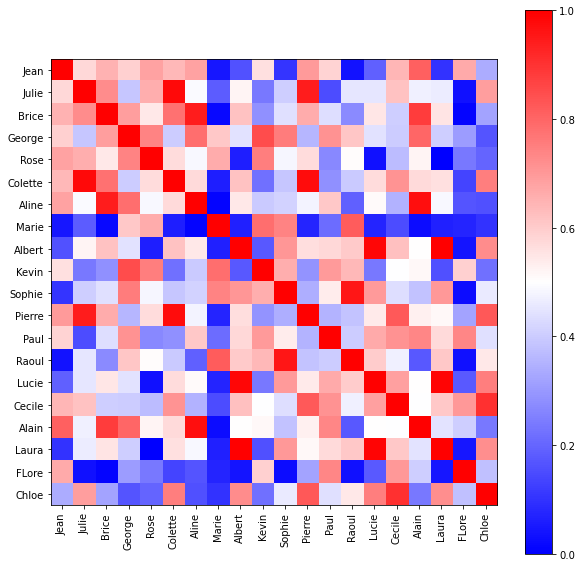

In [160]:
from sklearn.metrics.pairwise import cosine_similarity

users_similarity = cosine_similarity(W)

plt.figure(figsize=(10,10))
plt.imshow(users_similarity, cmap="bwr")
plt.colorbar()
plt.xticks(ticks=range(len(data.index.values)), labels=data.index.values, rotation="vertical")
plt.yticks(ticks=range(len(data.index.values)), labels=data.index.values)
plt.show()

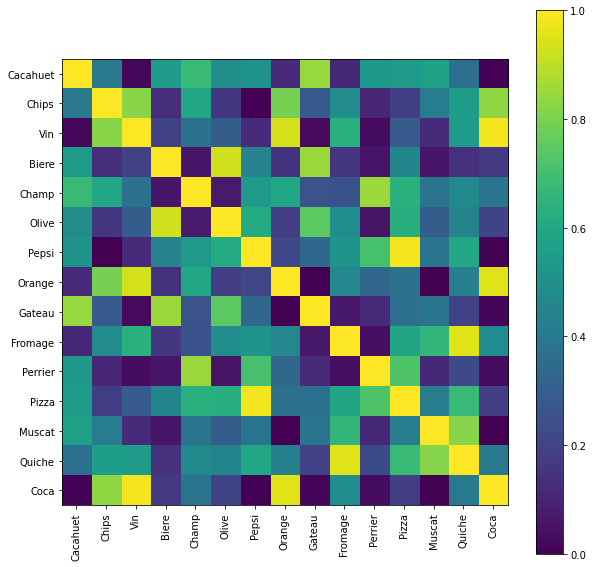

In [161]:
products_similarity = cosine_similarity(H.T)

plt.figure(figsize=(10,10))
plt.imshow(products_similarity)
plt.colorbar()
plt.xticks(ticks=range(len(data.columns.values)), labels=data.columns.values, rotation="vertical")
plt.yticks(ticks=range(len(data.columns.values)), labels=data.columns.values)
plt.show()

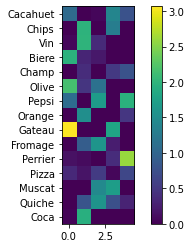

In [162]:
plt.imshow(H.T)
plt.colorbar()
plt.yticks(ticks=range(len(data.columns.values)), labels=data.columns.values)
plt.show()

In [187]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=5, compute_distances=True)
clusters_reduced = agg.fit_predict(H.T)

# plt.scatter(np.arange(agg.distances_.shape[0], 0, -1), agg.distances_)
# plt.show()

Plot Dendrogram


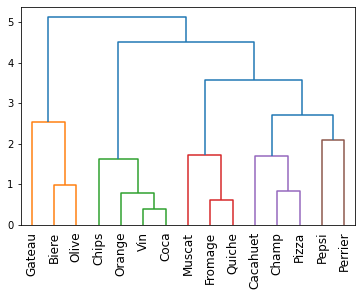

In [197]:
from scipy.cluster.hierarchy import dendrogram

print("Plot Dendrogram")

children = agg.children_
distances = agg.distances_
n_observations = np.arange(2, children.shape[0]+2)

linkage_matrix = np.c_[children, distances, n_observations]

thresh = 0.5 * (agg.distances_[-4] + agg.distances_[-5])
dendrogram(linkage_matrix, labels=data.columns.values, leaf_rotation=90, color_threshold=thresh)
plt.show()

In [192]:
print(agg.distances_)

[0.37324486 0.60305539 0.79118005 0.8274065  0.9818171  1.62685736
 1.68440288 1.72492834 2.08379185 2.53740626 2.70658985 3.5694038
 4.50105315 5.11329653]


In [183]:
agg = AgglomerativeClustering(n_clusters=5, compute_distances=True)
clusters_full_data = agg.fit_predict(data.T)

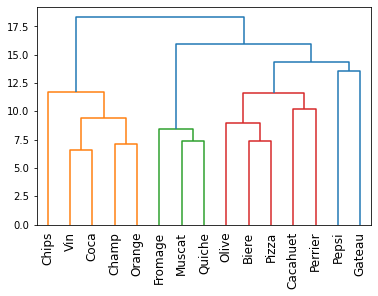

In [184]:
children = agg.children_
distances = agg.distances_
n_observations = np.arange(2, children.shape[0]+2)

linkage_matrix = np.c_[children, distances, n_observations]

dendrogram(linkage_matrix, labels=data.columns.values, leaf_rotation=90)
plt.show()

In [185]:
from sklearn.metrics import normalized_mutual_info_score

print(normalized_mutual_info_score(clusters_reduced, clusters_full_data))

0.7117182527586893
